In [164]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Prepare Data

In [165]:
# read data
spectrum_train = pd.read_excel('spectrum_train.xlsx')
spectrum_test = pd.read_excel('spectrum_valid.xlsx')
temp_train = pd.read_excel('temp_train.xlsx')
temp_test = pd.read_excel('temp_valid.xlsx')

In [166]:
# save spectrum labels for later
spectrum_labels = spectrum_test.columns

In [167]:
# scale spectrum data
scale = 10**12
spectrum_train = spectrum_train.multiply(scale)
spectrum_test = spectrum_test.multiply(scale)

In [168]:
from sklearn.model_selection import train_test_split
# set train and test data

# 1 - temp to spectrum
# 0 - spectrum to temp
direction = 0

# 1 - split training data
# 0 - use given training and validation data
split = 1

# use only if split == 1
# 1 - combine given training and validation data
# 0 - use only training data
combine = 0

if not split:
    if direction:
        X_train = temp_train
        X_test = temp_test
        y_train = spectrum_train
        y_test = spectrum_test
    else:
        X_train = spectrum_train
        X_test = spectrum_test
        y_train = temp_train
        y_test = temp_test
else:
    if combine:
        spectrum = pd.concat([spectrum_train, spectrum_test], axis=0)
        temp = pd.concat([temp_train, temp_test], axis=0)
    if direction:
        X_train, X_test, y_train, y_test = train_test_split(temp, spectrum, test_size=0.3, random_state=101)
    else:
        X_train, X_test, y_train, y_test = train_test_split(spectrum, temp, test_size=0.3, random_state=101)

In [169]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values.astype(np.float32)).to(device)

In [170]:
# create input and output tensors
X = df_to_tensor(X_train)
y = df_to_tensor(y_train)

In [171]:
n_samples, input_size = X.shape
_, output_size = y.shape

# Design Model 
(input size, output size, forward pass)

In [172]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 128)
        self.lin2 = nn.Linear(128, 128)
        self.lin3 = nn.Linear(128, 128)
        self.lin4 = nn.Linear(128, 128)
        self.lin5 = nn.Linear(128, 128)
        self.lin6 = nn.Linear(128, 128)
        self.lin7 = nn.Linear(128, 128)
        self.lin8 = nn.Linear(128, 128)
        self.lin9 = nn.Linear(128, 128)
        self.lin_fin = nn.Linear(128, output_size)

    def forward(self, x):
        output = F.leaky_relu(self.lin1(x))
        output = F.leaky_relu(self.lin2(output))
        output = F.leaky_relu(self.lin3(output))
        output = F.leaky_relu(self.lin4(output))
        output = F.leaky_relu(self.lin5(output))
        output = F.leaky_relu(self.lin6(output))
        output = F.leaky_relu(self.lin7(output))
        output = F.leaky_relu(self.lin8(output))
        output = F.leaky_relu(self.lin9(output))
        output = self.lin_fin(output)
        return output

In [173]:
model = Net(input_size=input_size, output_size=output_size)

# Construct Loss and Optimizer

In [174]:
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)

# Training Loop

In [175]:
loss_list = []
num_epochs = 5000
for epoch in range(num_epochs):
    # forward pass and loss
    y_predicted = model(X)
    loss = criterion(y_predicted, y)
    loss_list.append(loss.item())

    # backward pass
    loss.backward()

    # update
    optimizer.step()

    # empty gradients
    optimizer.zero_grad()

    if (epoch+1) % int(num_epochs/10) == 0:
        print(f'epoch: {epoch+1}, loss = {loss:.4f}')

epoch: 500, loss = 28.3461
epoch: 1000, loss = 26.6692
epoch: 1500, loss = 26.2113
epoch: 2000, loss = 25.9375
epoch: 2500, loss = 25.8196
epoch: 3000, loss = 25.7442
epoch: 3500, loss = 25.6470
epoch: 4000, loss = 25.5420
epoch: 4500, loss = 25.4513
epoch: 5000, loss = 25.3961


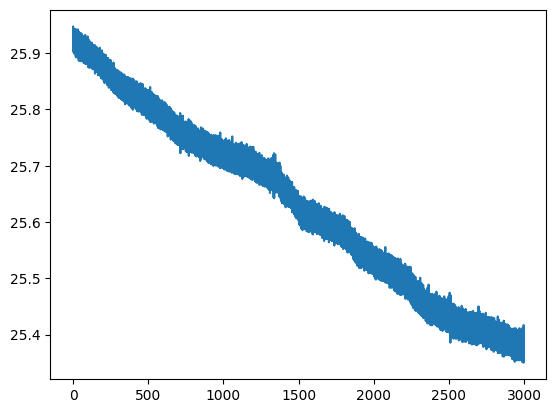

In [176]:
plt.plot(loss_list[2000:10000])

# Plots

In [177]:
pred = model(df_to_tensor(X_test))
pred = pd.DataFrame(pred.detach().numpy())

actual = y_test

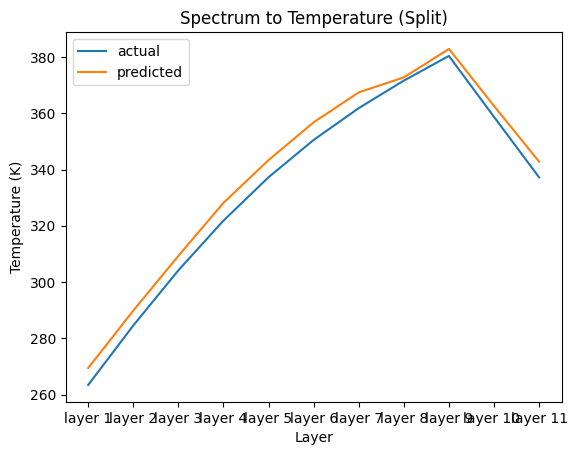

In [185]:
import matplotlib.pyplot as plt
import random

index = random.randint(0, len(actual))

actual_np = actual.values[index]
pred_np = pred.values[index]


plt.plot(y_train.columns, actual_np, label='actual')
plt.plot(y_train.columns, pred_np,  label='predicted')

if direction:
    if split:
        plt.title("Temperature to Spectrum (Split)")
    else:
        plt.title("Temperature to Spectrum (Given)")
    plt.xlabel("Wavlength")
    plt.ylabel("Intensity")
else:
    if split:
        plt.title("Spectrum to Temperature (Split)")
    else:
        plt.title("Spectrum to Temperature (Given)")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")

plt.legend()
plt.show()